# Task 1 - Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import geopy.distance

np.set_printoptions(suppress=True)
pd.set_option('expand_frame_repr', False)

trainData = pd.read_csv("train.csv",sep=",", nrows=10000000)
print("Train Data Info:", trainData.info())
print("Train Data Original Shape:", trainData.shape)


#Drop the key column
trainData.drop('key', axis=1, inplace=True)

#Remove all rows where any value is na
trainData.dropna(inplace=True)
print("Shape after dropping all NA :", trainData.shape)

#Remove all those rows where fare is -ve or fare >=300
trainData.drop(trainData[(trainData.fare_amount <= 0) | (trainData.fare_amount >= 300)].index, inplace=True)
print("Shape after cleaning fare feature :", trainData.shape)

#Remove all those rows where passenger count is less than 1
trainData.drop(trainData[trainData.passenger_count < 1].index, inplace=True)
print("Shape after cleaning passenger count feature :", trainData.shape)

# Latitude of NewYork = 40.730610, (between -90 to 90)
# Longitude of New York = -73.935242 (between -180 to 180)
# Remove all those rows where latitude <= -90 or latitude >= 90
# Remove all those rows where longitude >= 180 or longitude <= -180

minLatitude = 39
maxLatitude = 42
minLongitude = -75
maxLongitude = -72
trainData.drop(trainData[(trainData.pickup_longitude >= maxLongitude) | (trainData.pickup_longitude <= minLongitude)].index, inplace=True)
trainData.drop(trainData[(trainData.dropoff_longitude >= maxLongitude) | (trainData.dropoff_longitude <= minLongitude)].index, inplace=True)
trainData.drop(trainData[(trainData.pickup_latitude <= minLatitude) | (trainData.pickup_latitude >= maxLatitude)].index, inplace=True)
trainData.drop(trainData[(trainData.dropoff_latitude <= minLatitude) | (trainData.dropoff_latitude >= maxLatitude)].index, inplace=True)
print("Shape after cleaning latitude longitude feature :", trainData.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB
Train Data Info: None
Train Data Original Shape: (10000000, 8)
Shape after dropping all NA : (9999931, 7)
Shape after cleaning fare feature : (9999177, 7)
Shape after cleaning passenger count feature : (9963917, 7)
Shape after cleaning latitude longitude feature : (9755498, 7)


# Task 2 - Computing Pearson Coefficient

In [2]:
# Create an enriched model

# 1. Create a new column pickup_hour from pickup_datetime
def getHourOfPickUpTime(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').hour
trainData['pickup_hour'] = trainData['pickup_datetime'].map(getHourOfPickUpTime)

# 2. Create a new column pickup_week from pickup_datetime
def getWeekOfPickUpTime(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').weekday()
trainData['pickup_week'] = trainData['pickup_datetime'].map(getWeekOfPickUpTime)

# 2. Create a new column pickup_year from pickup_datetime
def getYearOfPickUpTime(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').year
trainData['pickup_year'] = trainData['pickup_datetime'].map(getYearOfPickUpTime)

# 3. Convert pickup_datetime to seconds
def getSeconds(x):
    curr = datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC')
    start = datetime(curr.year, curr.month, curr.day)
    return (curr - start).total_seconds()
trainData['pickup_datetime'] = trainData['pickup_datetime'].apply(getSeconds)

# 4. Add vincent distance to model
def vincent(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    a = np.array((pickup_longitude, pickup_latitude))
    b = np.array((dropoff_longitude, dropoff_latitude))
    return geopy.distance.vincenty(a, b).km
trainData['vincent_distance'] = list(map(vincent, trainData['pickup_longitude'], trainData['pickup_latitude'], trainData['dropoff_longitude'], trainData['dropoff_latitude']))

# 5. Add euclid distance to model
def euclid(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    a = np.array((pickup_longitude, pickup_latitude))
    b = np.array((dropoff_longitude, dropoff_latitude))
    return np.linalg.norm(a-b)
trainData['euclid_distance'] = list(map(euclid, trainData['pickup_longitude'], trainData['pickup_latitude'], trainData['dropoff_longitude'], trainData['dropoff_latitude']))

# Remove all rows where vincent distance is greater than 100Km
trainData.drop(trainData[(trainData.vincent_distance > 100) | (trainData.vincent_distance <= 0)].index, inplace=True)
print("Shape after adding new features :", trainData.shape)

Shape after adding new features : (9651483, 12)


In [15]:
# Display Correlation Matrix
correlation = trainData.corr(method='pearson')
print("Correlation value for euclid distance and distance travelled:", correlation['euclid_distance']['fare_amount'])
print("Correlation value for time of day in seconds and distance travelled:", correlation['pickup_datetime']['vincent_distance'])
print("Correlation value for time of day in seconds and taxi fare:", correlation['pickup_datetime']['fare_amount'])
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1)

Correlation value for euclid distance and distance travelled: 0.8086098738744738
Correlation value for time of day in seconds and distance travelled: -0.02780118411612378
Correlation value for time of day in seconds and taxi fare: -0.01734706425695645


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_week,pickup_year,vincent_distance,euclid_distance
fare_amount,1.0,-0.017,0.41,-0.19,0.31,-0.15,0.014,-0.017,0.0033,0.12,0.81,0.81
pickup_datetime,-0.017,1.0,0.019,0.023,-0.046,0.017,0.016,1.0,-0.087,4e-05,-0.028,-0.027
pickup_longitude,0.41,0.019,1.0,0.023,0.31,0.052,0.00053,0.019,-0.023,0.0093,0.52,0.47
pickup_latitude,-0.19,0.023,0.023,1.0,0.056,0.41,-0.0068,0.023,-0.035,-0.012,-0.17,-0.2
dropoff_longitude,0.31,-0.046,0.31,0.056,1.0,0.15,-0.0011,-0.046,-0.00082,0.0069,0.4,0.37
dropoff_latitude,-0.15,0.017,0.052,0.41,0.15,1.0,-0.0037,0.017,-0.027,-0.0058,-0.13,-0.17
passenger_count,0.014,0.016,0.00053,-0.0068,-0.0011,-0.0037,1.0,0.016,0.035,0.0042,0.0083,0.0085
pickup_hour,-0.017,1.0,0.019,0.023,-0.046,0.017,0.016,1.0,-0.088,-1.5e-05,-0.028,-0.027
pickup_week,0.0033,-0.087,-0.023,-0.035,-0.00082,-0.027,0.035,-0.088,1.0,0.0063,0.0043,0.012
pickup_year,0.12,4e-05,0.0093,-0.012,0.0069,-0.0058,0.0042,-1.5e-05,0.0063,1.0,0.019,0.016


# Task 3 - Plotting Pearson Coefficients

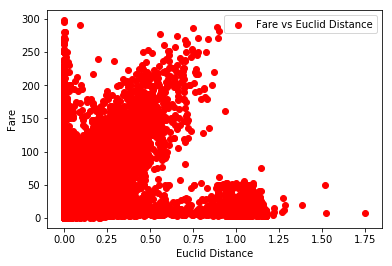

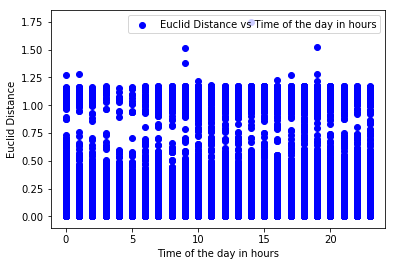

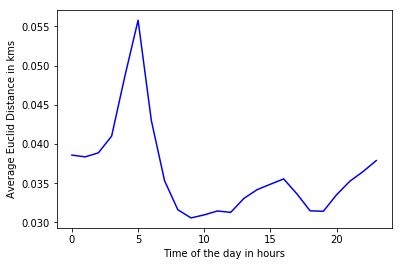

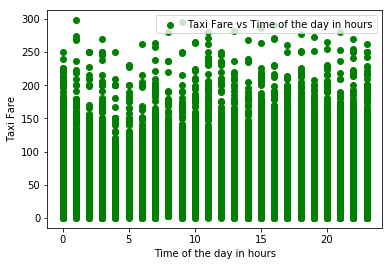

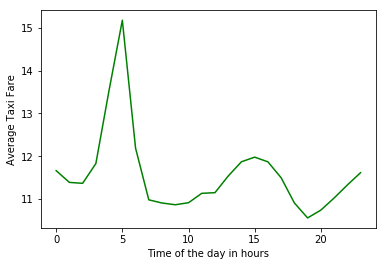

In [16]:
# Plotting Taxi Fare vs Euclid Distance
plt.scatter(trainData.euclid_distance, trainData.fare_amount, color='red', label='Fare vs Euclid Distance')
plt.legend(loc='upper right')
plt.xlabel('Euclid Distance')
plt.ylabel('Fare')
plt.show()

plt.scatter(trainData.pickup_hour, trainData.euclid_distance, color='blue', label='Euclid Distance vs Time of the day in hours')
plt.legend(loc='upper right')
plt.xlabel('Time of the day in hours')
plt.ylabel('Euclid Distance')
plt.show()

groupby_pickup_hour = trainData.groupby(['pickup_hour']).mean()
plt.plot(groupby_pickup_hour.euclid_distance, color='blue')
plt.xlabel('Time of the day in hours')
plt.ylabel('Average Euclid Distance in kms')
plt.show()

plt.scatter(trainData.pickup_hour, trainData.fare_amount, color='green', label='Taxi Fare vs Time of the day in hours')
plt.legend(loc='upper right')
plt.xlabel('Time of the day in hours')
plt.ylabel('Taxi Fare')
plt.legend(loc='upper right')
plt.show()

plt.plot(groupby_pickup_hour.fare_amount, color='green')
plt.xlabel('Time of the day in hours')
plt.ylabel('Average Taxi Fare')
plt.show()

As seen in the 1st chart, there is a strong linear relationship between distance and taxi fare.
As the distance travelled increases, taxi fare increases as well.

Does the length of the trips people take varies by different times of day?
As per the 2nd chart, No. The scatter plot is not very helpful in analyzing this.
But the line chart (3rd Chart) clearly tells us that the length of thr trips is larger around 5AM in the morning.
People travel over longer distances between 4-6 in the morning.

Does the taxi fare varies by different times of day?
Again the 4th scatter plot does not explain this very well.
But the line plot clearly explains that the average taxi fare is higher around 5 AM.
Since longer trips are taken in the morning and taxi fare correlates with distance, a higher taxi fare in the moring is understandable.

# Task 4 - Exciting Plot

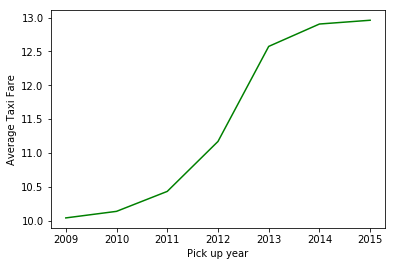

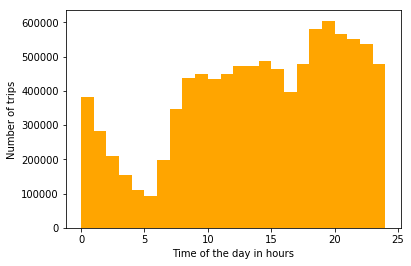

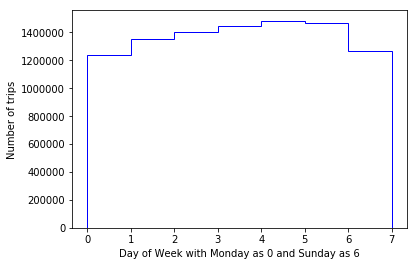

In [17]:
groupby_pickup_year = trainData.groupby(['pickup_year']).mean()
plt.plot(groupby_pickup_year.fare_amount, color='green')
plt.xlabel('Pick up year')
plt.ylabel('Average Taxi Fare')
plt.show()

plt.hist(trainData.pickup_hour, color='orange', bins=np.arange(trainData.pickup_hour.min(), trainData.pickup_hour.max()+2))
plt.xlabel('Time of the day in hours')
plt.ylabel('Number of trips')
plt.show()

plt.hist(trainData.pickup_week, histtype='step',color='blue', bins=np.arange(trainData.pickup_week.min(), trainData.pickup_week.max()+2))
plt.xlabel('Day of Week with Monday as 0 and Sunday as 6')
plt.ylabel('Number of trips')
plt.show()

Analysis of Chart 1
The taxi fare increases drastically over the years. This may be due to inflation

Analysis of Chart 2
Number of trips increase through the time of day
Very few trips happen between 4 to 6 AM in the morning
Maximum number of trips occur in the evening(between 6PM to 12 PM )

Analysis of Chart 3
The number of trips on each day remains almost constant
Most number of trips happen on friday. As friday is starting of weekend, it makes sense that people use more cabs for shopping and visiting places in NYC.

# Task 5 - Additional Features

Additional features that cannot be derived from given data

1. Cab Type - High end cars like Tesla Electric Cars or Convertibles when used as Taxi will have higher fare than low end car

2. Hourly weather (Sunny, Rainy, Snowy) - Many a times cabs have dynamic pricing. They charge more fare in inclement weather due to high demand. Ex. on a rainy day

3. Waiting Time of the taxi - People sometimes make the taxi wait. Thus taxi's charge waiting time as well. This also accounts for the time lost by cabs in traffic.

4. Event Dates in NYC - The taxi fares would be higher on days like 31st December, Black Friday Sale, Thanksgiving, etc due to high demand. Such data can also be considered in the model.

5. Toll Charges

6. Any Discount Scheme Running

Features that can be derived from given data

1. Is pickup or drop at Airport - Cabs coming to and from airport usually have fixed fares. JFK airport has coordinates of 40.6413° N, 73.7781° W. From latitude and longitude data, we can create a binary variable

2. Day of the week - As seen in the charts, people use more cabs on weekends than rest of the week.

3. Year - As seen in the analysis, taxi fares increase a lot over the years. Thus year should be a separate feature.

# Task 6 - Simple Linear Regression Model

In [18]:
# Training Features - Cleaned
trainX = pd.DataFrame({
    'pickup_longitude': trainData.pickup_longitude,
    'pickup_latitude': trainData.pickup_latitude,
    'dropoff_longitude': trainData.dropoff_longitude,
    'dropoff_latitude' : trainData.dropoff_latitude,
    'passenger_count': trainData.passenger_count,
    'pickup_hour' : trainData.pickup_hour,
    'vincent_distance' : trainData.vincent_distance,
    'pickup_year': trainData.pickup_year
})

# Training Labels - Cleaned
trainY = trainData.fare_amount

# Simple Linear Regression
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

scaler = preprocessing.StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)
regr = linear_model.LinearRegression()
model = regr.fit(trainX, trainY)
predictedY = regr.predict(trainX)

print('Weights',
    '\npickup_longitude',regr.coef_[0],
    '\npickup_latitude', regr.coef_[1], 
    '\ndropoff_longitude ', regr.coef_[2], 
    '\ndropoff_latitude ', regr.coef_[3], 
    '\npassenger_count ', regr.coef_[4], 
    '\npickup_hour ', regr.coef_[5], 
    '\nvincent_distance ',regr.coef_[6], 
    '\npickup_year ',regr.coef_[7]
     )
print("\nLinear Regression Train MSE: ", mean_squared_error(trainY, predictedY))
print("Linear Regression R^2 Score without Cross Validation:", model.score(trainX, trainY))

# Cross validation is useful when we have to choose hyperparameter values
print("Cross Validated R^2 Score: ", cross_val_score(model, trainX, trainY, cv=5))

Weights 
pickup_longitude 0.05250242361136319 
pickup_latitude -0.40942370416893603 
dropoff_longitude  -0.0787757355347058 
dropoff_latitude  -0.29737706293913724 
passenger_count  0.06208915291506288 
pickup_hour  0.05517819582632786 
vincent_distance  7.619066323671145 
pickup_year  0.9777303998374416

Linear Regression Train MSE:  30.94308683316811
Linear Regression R^2 Score without Cross Validation: 0.6642898279774317
Cross Validated R^2 Score:  [0.65893787 0.66354406 0.66660628 0.66679204 0.66551396]


# Task 7 - Additional Relevant Datasets


1. https://data.cityofnewyork.us/Transportation/2017-Green-Taxi-Trip-Data/5gj9-2kzx - 2017 Green Taxi Trip Data
This is latest data and thus it can predict the fares very accurately. It has extra features like Toll fares, Trip Type (Street-hail, dispatch), Tip Amount, MTA Taxes, Improvement Surcharge, Payment Type, etc.
I was able to use this dataset to understand how tip amounts impact the taxi fares in NYC. 
As this dataset is only for 2017, it couldn't be added as feature in our model.

1. https://www.kaggle.com/c/nyc-taxi-trip-duration/data (Data for year 2016) - Provided by NYC Taxi and Limousine Commission Data
This has trip duration data which can be a very good feature for taxi fare precition.
On analysing this dataset, I found that trip duration is highly correlated to taxi fares.

2. https://www.kaggle.com/atmarouane/nyc-taxi-trip-noisy/home - - Additional Data 
(Src County, Dest County, Number of traffic signals, Number of pedestrians crossing, Number of intersection, Number of Stop Signs) - The popular location names or frequent county names can be encoded using one hot encoder

3. https://search.datacite.org/works/10.13012/J8PN93H8 - Published by University of Illinois at Urbana-Champaign
    (NYC Taxi Data from 2010 to 2013)
This has large number of records of older data.

# Task 8 - Better Prediction Model

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.svm import SVR

scaler = preprocessing.StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)

print("Random Forest Model")
regr1 = RandomForestRegressor(max_depth=4, random_state=0)
model = regr1.fit(trainX, trainY.values.ravel())
trainMse = mean_squared_error(trainY, regr1.predict(trainX))
print("Weights: ", regr1.feature_importances_)
print("Train MSE: ", trainMse)

print("\nRidge Regression")
regr2 = linear_model.RidgeCV()
model = regr2.fit(trainX, trainY)
trainMse = mean_squared_error(trainY, regr2.predict(trainX))
print("Weights: ", regr2.coef_)
print("Train MSE: ", trainMse)

print("\nLasso Regression")
regr3 = linear_model.Lasso()
model = regr3.fit(trainX, trainY)
trainMse = mean_squared_error(trainY, regr3.predict(trainX))
print("Weights: ", regr3.coef_)
print("Train MSE: ", trainMse)

Random Forest Model
Weights:  [0.         0.         0.0121238  0.01964589 0.         0.
 0.95607016 0.01216015]
Train MSE:  24.748604539086827

Ridge Regression
Weights:  [ 0.05250787 -0.40942507 -0.07877191 -0.29737867  0.06208919  0.05517792
  7.61905372  0.97772953]
Train MSE:  30.943086833267248

Lasso Regression
Weights:  [ 0.         -0.          0.         -0.          0.          0.
  6.73926302  0.0016395 ]
Train MSE:  33.272122591987795


# Task 9 - Predicting Taxi Fares

In [22]:
# Create test data for regression
testData = pd.read_csv("test.csv",sep=",")

testData['pickup_hour'] = testData['pickup_datetime'].map(getHourOfPickUpTime)
testData['pickup_year'] = testData['pickup_datetime'].map(getYearOfPickUpTime)
testData['pickup_datetime'] = testData['pickup_datetime'].apply(getSeconds)
testData['vincent_distance'] = list(map(vincent, testData['pickup_longitude'], testData['pickup_latitude'], testData['dropoff_longitude'], testData['dropoff_latitude']))

testX = pd.DataFrame({
    'pickup_longitude': testData.pickup_longitude,
    'pickup_latitude': testData.pickup_latitude,
    'dropoff_longitude': testData.dropoff_longitude,
    'dropoff_latitude' : testData.dropoff_latitude,
    'passenger_count': testData.passenger_count,
    'pickup_hour' : testData.pickup_hour,
    'vincent_distance' : testData.vincent_distance,
    'pickup_year': testData.pickup_year
})

# Normalize
testX = scaler.transform(testX)

# Predict on the best regression model
testY = regr1.predict(testX)
testYDf = pd.DataFrame(testY.ravel(), columns=['fare_amount'])
outputDf = pd.concat([testData.key, testYDf], axis=1)
outputDf.to_csv('predTestLabels.csv', index=False)